In [55]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import math

In [10]:
dataset_location = "/eos/home-m/mmatthew/Patatrack13/Cone-Graph-building/Playground/data/vanilla"
trainDataset = torch.load(os.path.join(dataset_location,"dataTraining.pt"))[:10000]

# Investigate Node Features

The node features are:
- barycenter_x
- barycenter_y
- barycenter_z
- evector_x
- evector_y
- evector_z
- EV1
- EV2
- EV3
- SigmaPCA1
- SigmaPCA2
- SigmaPCA3
- trackster_sizes
- raw_energy
- raw_em_energy

In [23]:
raw_energy = []
sc_energy = []
num_tracksters = []
for evt in trainDataset:
    raw_energy.append(evt.x[:,13].numpy())
    sc_energy.append(evt.sc_energy.numpy())
    num_tracksters.append(evt.x[:,12].numpy())

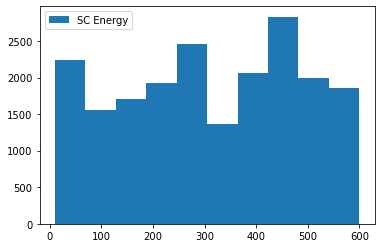

In [40]:
# SC Energy
plt.hist(np.array(sc_energy).flatten(),label="SC Energy")
plt.legend()

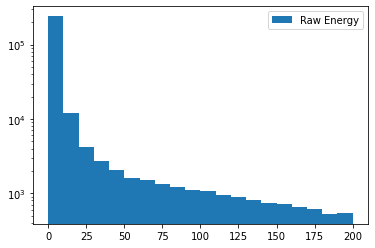

In [39]:
# Raw Energy

raw_energy_flat = [x for y in raw_energy for x in y]
plt.hist(np.array(raw_energy_flat).flatten(),bins = 20, range=[0,200],label="Raw Energy")
plt.yscale("log")
plt.legend()

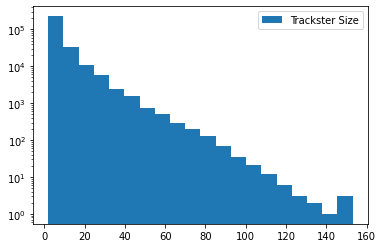

In [61]:
# Trackster size

num_tracksters_flat = [x for y in num_tracksters for x in y]
plt.hist(np.array(num_tracksters_flat).flatten(),bins = 20,label="Trackster Size")
plt.yscale("log")
plt.legend()

In [57]:
def plot_energy_regression_histograms(histos, rng, nbins):
    # The function takes as input a dictionary of histograms, the range for the x axis, and the number of bins
    # for the energy fractions, regressed and unregressed, and for 6 different energy ranges [0,100,200,300,400,500,600]
    
    x = np.linspace(rng[0],rng[1],nbins)
    bs = x[1]-x[0]
    rows = math.ceil(len(histos["unregressed"].keys())/3)
    fig, axs = plt.subplots(rows,3,figsize=(15,15))
    i,j = 0,0 
    for energy in histos["unregressed"].keys():
        axs[i,j].step(x,histos["unregressed"][energy],label="unregressed energy frac.")
        axs[i,j].grid()
        axs[i,j].legend()
        axs[i,j].set_title("<%i00 GeV"%(energy+1))
        axs[i,j].set_xlabel(r"$en_{TRKs}/en_{SC}$")
        j=j+1
        if j%3==0:
            i=i+1
            j=0
    fig.suptitle("Energy Regression Histograms")

    plt.tight_layout()
    return fig

def get_regressed_sc_energy(pred_trk_energy,sc_trk_match,sc_energy):
    pred_sc_energy = torch.tensor([])
    for i in range(len(sc_energy)):
        idx = torch.where(sc_trk_match==i,1,0).nonzero()
        if pred_sc_energy.numel()==0:
            pred_sc_energy = pred_trk_energy[idx].sum().unsqueeze(dim=0)
        else:
            pred_sc_energy = torch.cat((pred_sc_energy,pred_trk_energy[idx].mean().unsqueeze(dim=0)),dim=0)
    return pred_sc_energy

In [58]:
# Energy Fraction

rng = [0,2]
nbins = 50
nhists = 6
bs = (rng[1]-rng[0])/nbins
reg_histos = {"unregressed":{}}
for i in range(nhists):
    reg_histos["unregressed"][i]=np.zeros(nbins)

for sample in trainDataset:
    unregressed_sc_energy = get_regressed_sc_energy(sample.x[:,13].unsqueeze(dim=1),sample.best_simTs_match,sample.sc_energy)
    non_nan_idx = np.array(torch.nonzero(~torch.isnan(unregressed_sc_energy)).squeeze().cpu())

    if not np.any(non_nan_idx): continue
    for ele in non_nan_idx:
        eidx = int(sample.sc_energy[ele]/100)
        unregressed_frac = unregressed_sc_energy[ele]/sample.sc_energy[ele]
        idx = int(unregressed_frac/bs)
        if idx > 49: # Bug: Something seems to be wrong with the calculation
            continue
        reg_histos["unregressed"][eidx][idx] +=1


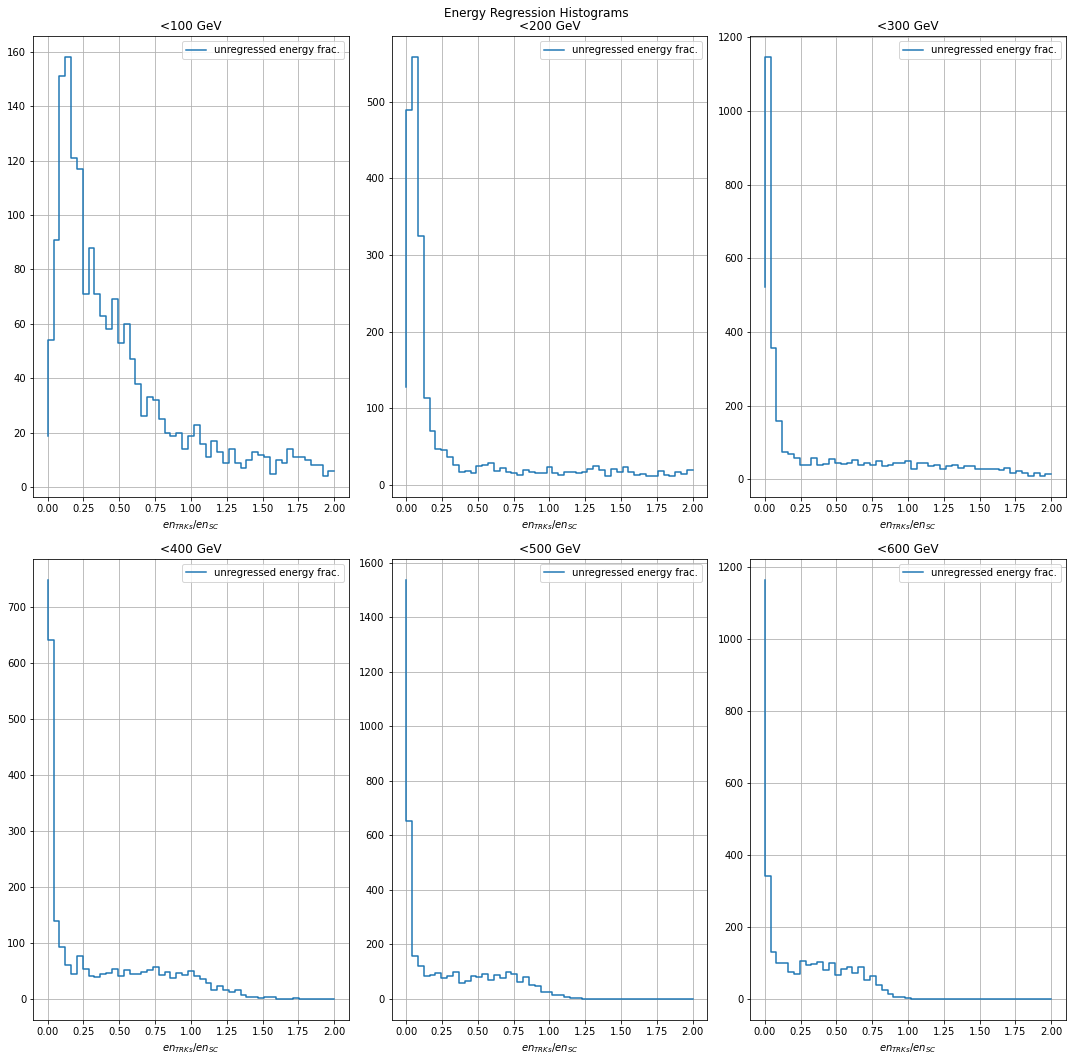

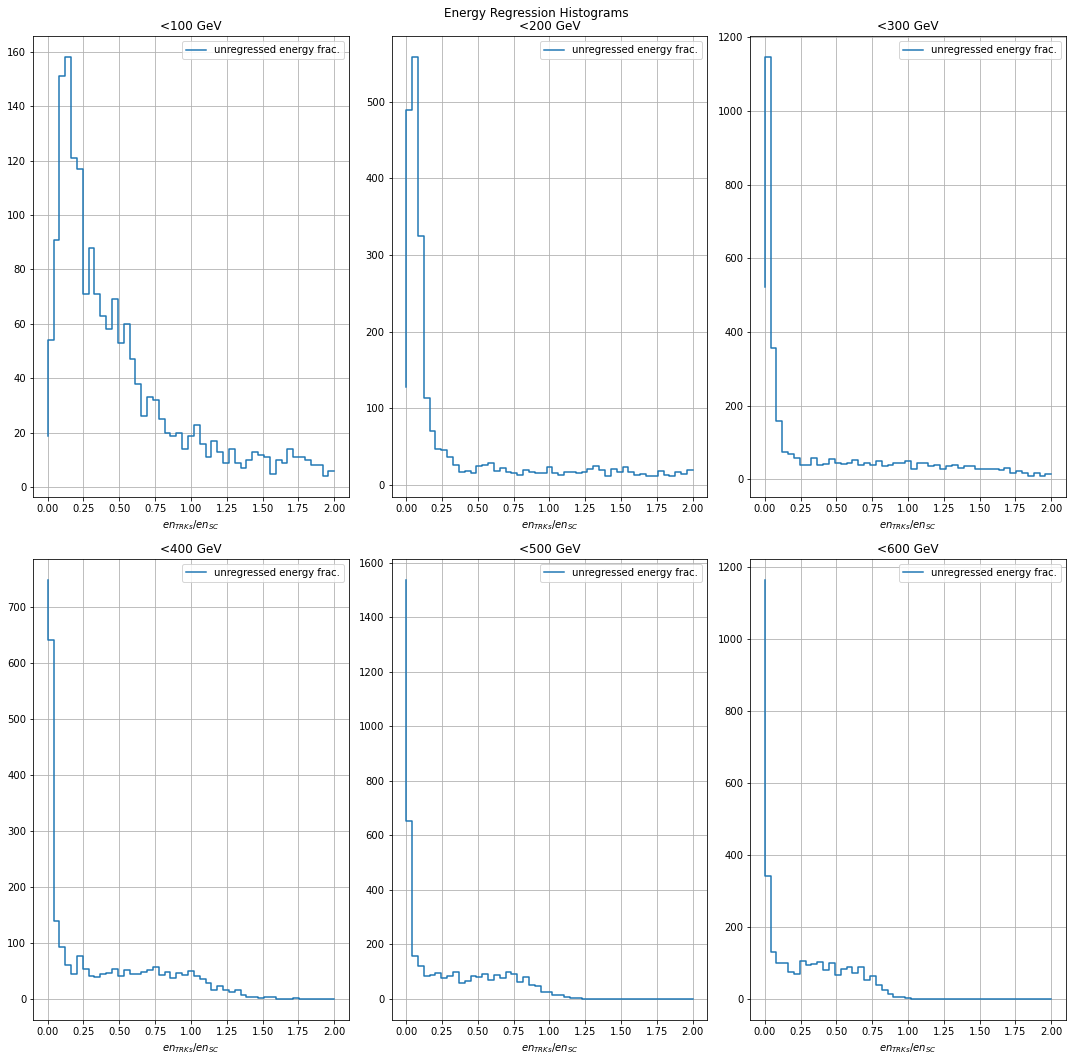

In [59]:
plot_energy_regression_histograms(reg_histos, rng, nbins)

# Investigate Edges

Check Kate's thesis or ask Alex if he has something already